In [7]:
"""
use it like 
python calibrate_camera.py --image_dir /home/fari/Pictures/calibrationcheckerboard/calibration --image_format jpg --square_size 2.5 --width 10 --height 7 --save_file ./calibration.yml --ref_plan /home/fari/Pictures/calibrationcheckerboard/ref_plan.jpg
"""
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


def plot_image(img):
    fig, ax = plt.subplots(1)
    ax.imshow(img) 
    plt.axis('off')
    plt.show()


def add_points_on_image(img, points, color=(0, 255, 0), size=5, thickness=-1):
    """
    Plots a set of points on an image.
    
    Parameters:
        img (ndarray): The image on which to plot the points.
        points (list or ndarray): A list or array of (x, y) points.
        color (tuple): The color of the points in (B, G, R) format. Default is green.
        size (int): The radius of the points. Default is 5.
        thickness (int): The thickness of the points. If -1, the point will be filled. Default is -1.
        
    Returns:
        ndarray: The image with the points plotted.
    """
    
    for point in points:
        cv2.circle(img, (int(point[0]), int(point[1])), size, color, thickness)
    
    return img

def calibrate(dirpath, image_format, square_size, ref_plan_path, width, height):
    """ Apply camera calibration operation for images in the given directory path. """
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,6,0)
    objp = np.zeros((height*width, 3), np.float32)
    objp[:, :2] = np.mgrid[0:width, 0:height].T.reshape(-1, 2)

    #objp = objp * square_size
    objp = objp 

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d point in real world space
    imgpoints = []  # 2d points in image plane.

    if dirpath[-1:] == '/':
        dirpath = dirpath[:-1]

    images = glob.glob(dirpath+'/' + '*.' + image_format)
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (width, height), None)

        # If found, add object points, image points (after refining them)
        if ret:
            objpoints.append(objp)

            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            imgpoints.append(corners2)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (width, height), corners2, ret)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    #find homography
    ref_plan = cv2.imread(ref_plan_path)
    gray = cv2.cvtColor(ref_plan, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (width, height), None)
    if ret:
        #plot corners
        

        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        # Define the world coordinates of the checkerboard corners
        # For simplicity, let's assume each square in the checkerboard has a size of 1 unit (e.g., meter
        world_points = np.zeros((width*height, 2), dtype=np.float32)
        for i in range(width):
            for j in range(height):
                world_points[i*height + j] = [i, j]
        print(len(world_points))
        print(len(corners2))
        print(world_points[0])
        print(corners2[0])
        print(world_points[1])
        print(corners2[1])
        cv2.imshow('Image with Points', add_points_on_image(ref_plan, corners2[1]))
        cv2.waitKey(0)
        cv2.destroyAllWindows()

        # Compute the homography
        H, _ = cv2.findHomography(corners2 , world_points)

    return [ret, mtx, dist, rvecs, tvecs, H]


def save_coefficients(mtx, dist, H, path):
    """ Save the camera matrix, distortion coefficients and perspective matrix to given path/file. """
    cv_file = cv2.FileStorage(path, cv2.FILE_STORAGE_WRITE)
    cv_file.write("K", mtx)
    cv_file.write("D", dist)
    cv_file.write("H", H)
    cv_file.release()

# Also, modify the load_coefficients function to retrieve the perspective matrix
def load_coefficients(path):
    """ Loads camera matrix, distortion coefficients and perspective matrix. """
    cv_file = cv2.FileStorage(path, cv2.FILE_STORAGE_READ)
    camera_matrix = cv_file.getNode("K").mat()
    dist_matrix = cv_file.getNode("D").mat()
    H = cv_file.getNode("H").mat()
    cv_file.release()
    return [camera_matrix, dist_matrix, H]


def undistort_image(img_path, calibration_file):
    """
    Load the coefficients, undistort and warp the input image.
    
    Parameters:
    - img_path: Path to the image to be undistorted and warped.
    - calibration_file: Path to the YML file with calibration matrices.
    
    Returns:
    - undistorted_img: Undistorted image.
    """
    
    # 1. Load the coefficients
    camera_matrix, dist_coeffs, perspective_matrix = load_coefficients(calibration_file)
    # 2. Undistort the image
    img = cv2.imread(img_path)
    undistorted_img = cv2.undistort(img, camera_matrix, dist_coeffs)
    return undistorted_img

def transform_bbox_to_world(bbox, H):
    """
    Transforms an image bounding box to a 2D world coordinate bounding box.
    
    Parameters:
    - bbox: A tuple (x, y, w, h) representing the image bounding box.
    - H: The homography matrix.
    
    Returns:
    - A tuple (X_min, Y_min, X_max, Y_max) representing the world bounding box.
    """
    
    x, y, w, h = bbox
    corners_image = np.array([
        [[x, y]],
        [[x + w, y]],
        [[x, y + h]],
        [[x + w, y + h]]
    ], dtype=np.float32)
    
    corners_world = cv2.perspectiveTransform(corners_image, H)
    
    X_coords = corners_world[:, 0, 0]
    Y_coords = corners_world[:, 0, 1]
    
    X_min, X_max = np.min(X_coords), np.max(X_coords)
    Y_min, Y_max = np.min(Y_coords), np.max(Y_coords)
    
    return (X_min, Y_min, X_max, Y_max)


image_dir = "/home/fari/Pictures/calibrationcheckerboard/calibration"
square_size=2.5
width=10
height=7
image_format="jpg"
save_file="./calibration.yml" 
ref_plan="/home/fari/Pictures/calibrationcheckerboard/ref_plan.jpg"

ret, mtx, dist, rvecs, tvecs, H = calibrate(image_dir, image_format, square_size, ref_plan, width, height)
    
save_coefficients(mtx, dist, H, save_file)
print("Calibration is finished. RMS: ", ret)



70
70
[0. 0.]
[[450.37308 309.46057]]
[0. 1.]
[[514.63477 309.91403]]


In [8]:
import numpy as np
import cv2

def transform_bbox_to_world(bbox, H):
    """
    Transforms an image bounding box to a 2D world coordinate bounding box.
    
    Parameters:
    - bbox: A tuple (x, y, w, h) representing the image bounding box.
    - H: The homography matrix.
    
    Returns:
    - A tuple (X_min, Y_min, X_max, Y_max) representing the world bounding box.
    """
    
    x, y, w, h = bbox
    corners_image = np.array([
        [[x, y]],
        [[x + w, y]],
        [[x, y + h]],
        [[x + w, y + h]]
    ], dtype=np.float32)
    
    corners_world = cv2.perspectiveTransform(corners_image, H)
    
    X_coords = corners_world[:, 0, 0]
    Y_coords = corners_world[:, 0, 1]
    
    X_min, X_max = np.min(X_coords), np.max(X_coords)
    Y_min, Y_max = np.min(Y_coords), np.max(Y_coords)
    
    return (X_min, Y_min, X_max, Y_max)


def load_coefficients(path):
    """ Loads camera matrix, distortion coefficients and perspective matrix. """
    cv_file = cv2.FileStorage(path, cv2.FILE_STORAGE_READ)
    camera_matrix = cv_file.getNode("K").mat()
    dist_matrix = cv_file.getNode("D").mat()
    H = cv_file.getNode("H").mat()
    cv_file.release()
    return [camera_matrix, dist_matrix, H]


mtx, dist, H = load_coefficients("calibration.yml")

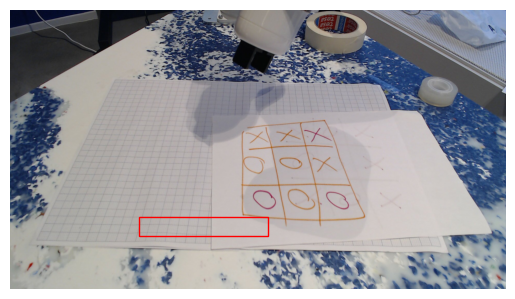

In [16]:

img = cv2.imread("test.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Bounding box format: (x, y, width, height)
bbox = (500, 800, 500, 75)  # Example values

fig, ax = plt.subplots(1)
ax.imshow(img_rgb)

# Create a rectangle for the bounding box
rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.axis('off')
plt.show()




In [17]:
transform_bbox_to_world(bbox, H)

(11.286463, 3.466524, 12.099736, 3.556223)

In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def draw_world_origin_on_image(image_path, mtx, dist, rvecs, tvecs, square_size):
    """
    Draws the world origin and axes on the given image.

    Parameters:
    - image_path: Path to the input image.
    - mtx: Camera matrix.
    - dist: Distortion coefficients.
    - rvecs: Rotation vector for the image.
    - tvecs: Translation vector for the image.
    - square_size: Size of a square in the checkerboard.

    Returns:
    - img: Image with the world origin drawn on it.
    """

    img = cv2.imread(image_path)
    
    # Define 3D points for the world origin and axes (X, Y, Z)
    origin = np.array([[0, 0, 0], 
                       [square_size * 3, 0, 0], 
                       [0, square_size * 3, 0], 
                       [0, 0, -square_size * 3]], dtype=np.float32)
    
    # Project 3D points to the image plane
    img_pts, _ = cv2.projectPoints(origin, rvecs, tvecs, mtx, dist)

    # Draw the world axes on the image
    cv2.line(img, tuple(img_pts[0].ravel()), tuple(img_pts[1].ravel()), (255,0,0), 5)  # X-axis (Red)
    cv2.line(img, tuple(img_pts[0].ravel()), tuple(img_pts[2].ravel()), (0,255,0), 5)  # Y-axis (Green)
    cv2.line(img, tuple(img_pts[0].ravel()), tuple(img_pts[3].ravel()), (0,0,255), 5)  # Z-axis (Blue)

    return img


draw_world_origin_on_image("test.jpg", mtx, dist, rvecs, tvecs, square_size)

error: OpenCV(4.8.1) :-1: error: (-5:Bad argument) in function 'projectPoints'
> Overload resolution failed:
>  - rvec is not a numerical tuple
>  - Expected Ptr<cv::UMat> for argument 'rvec'
